## Definições iniciais
Esta seção compõe a base para a execução das análises deste notebook. As funções de manipulação de dados foram todas definidas aqui para apenas serem utilizadas na parte de visualização, reduzindo a quantidade de código onde as conclusões são mais importantes.

Como objetivo final, este estudo busca entender o racional de alocação de UBS por um estado. Descoberta a lógica, segue-se para a crítica da mesma, com a possível criação de um modelo capaz de executar com eficiência uma alocação de nova UBS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
base_path = "/media/bruno/Arquivos/Desenvolvimento/UBS"
def get_dataset() -> pd.DataFrame:
    dataset = pd.read_csv(f"{base_path}/data/dataset.csv")
    return dataset.query("UF != 'DF'")


def sort_with_category(x: list, y: list) -> None:
    for i in range(0, len(y)):
        for j in range(i + 1, len(y)):
            if y[j] > y[i]:
                y[i], y[j] = y[j], y[i]
                x[i], x[j] = x[j], x[i]


def fill_nan(df: pd.DataFrame, column: str) -> pd.DataFrame:
    total, quantity, values = 0, 0, []
    for i in range(0, len(df)):
        if df[column].values[i] == 0 or df[column].values[i] == np.nan:
            continue

        total = total + df[column].values[i]
        quantity = quantity + 1

    mean = total / quantity if quantity != 0 else 0
    for i in range(0, len(df)):
        if df[column].values[i] == 0 or df[column].values[i] == np.nan:
            values.append(mean)
        else:
            values.append(df[column].values[i])
    
    df[column] = values
    return df


def get_color(key):
    if key == "black":
        return "#808080"
    elif key == "focus":
        return "#f3e79d"

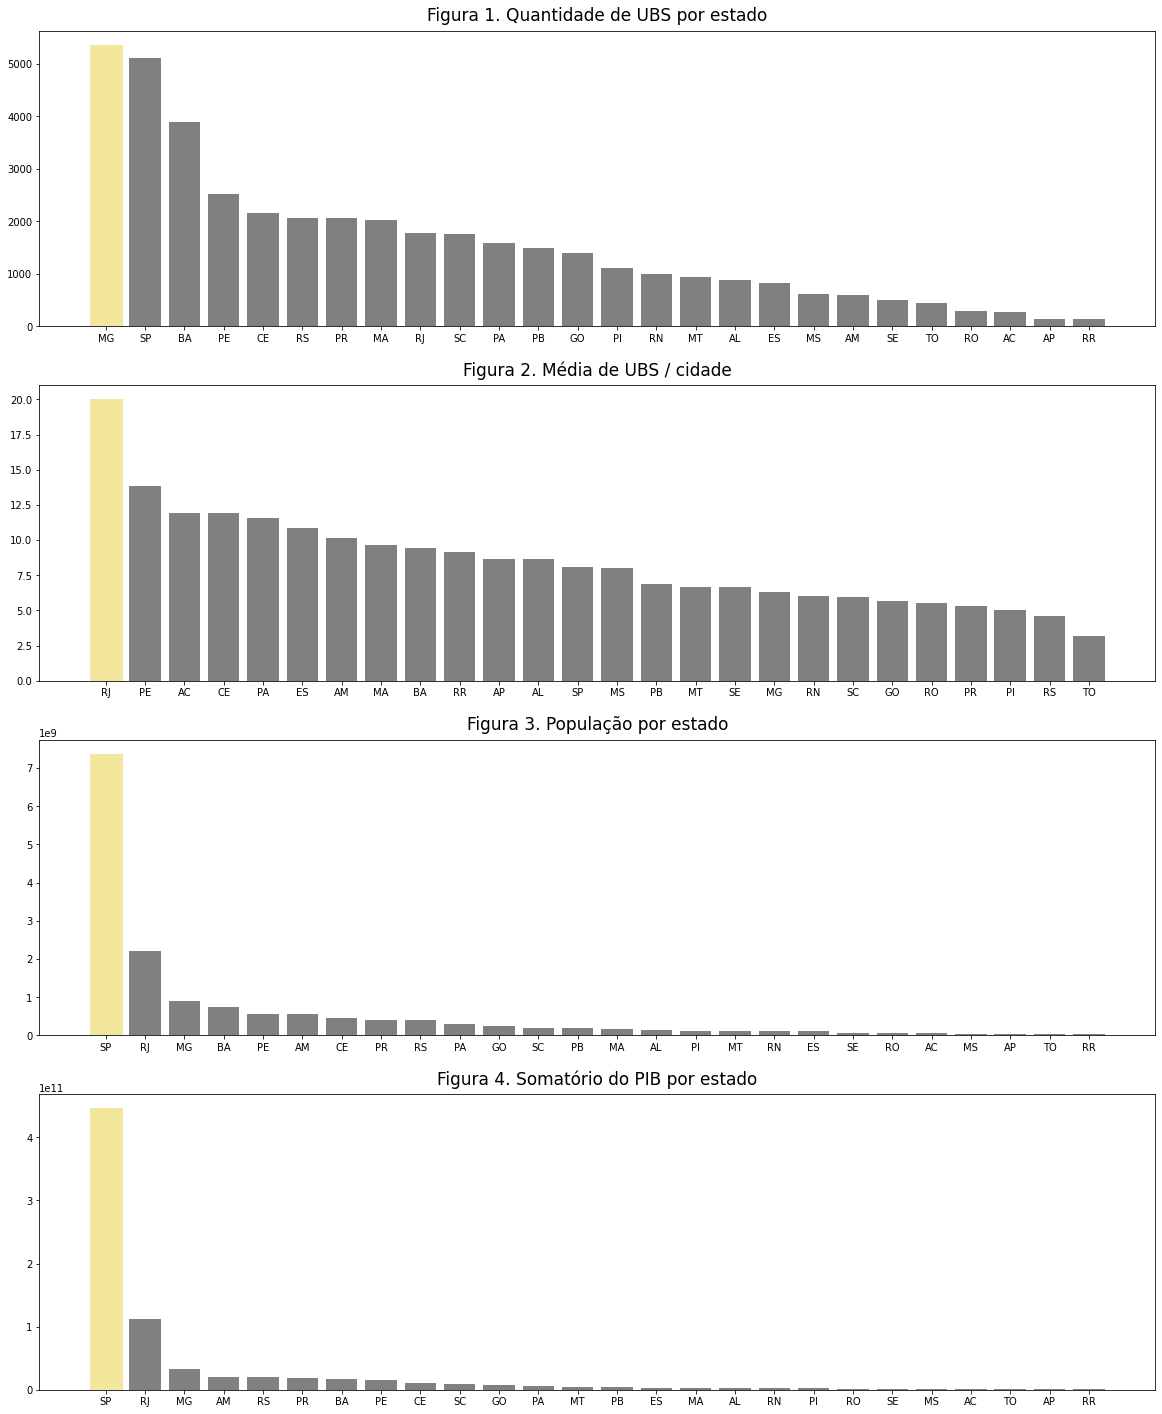

In [58]:
def view_distribution():
    # Carrega dataset e variáveis para plot
    dataset = get_dataset()
    x_ubs, y_ubs = [], []
    x_pop, y_pop = [], []
    x_pib, y_pib = [], []
    x_rel, y_rel = [], []

    # Calcula a quantidade de UBS em cada estado
    serie = dataset["UF"].value_counts()
    for index in serie.index:
        x_ubs.append(index)
        y_ubs.append(serie[index])
    sort_with_category(x_ubs, y_ubs)

    # Calcula a média de UBS / Cidade em cada estado
    for index in serie.index:
        cities = len(dataset.query(f"UF == '{index}'")["CITY"].unique())
        x_rel.append(index)
        y_rel.append(serie[index] / cities if cities != 0 else 0)
    sort_with_category(x_rel, y_rel)

    # Calcula a quantidade de pessoas em cada estado e o PIB
    dataset = fill_nan(dataset, "PIB_2019")
    dataset = fill_nan(dataset, "POPULATION_2021")
    group = dataset.groupby("UF")[["POPULATION_2021", "PIB_2019"]].agg("sum")

    for index in group["POPULATION_2021"].index:
        x_pop.append(index)
        y_pop.append(group["POPULATION_2021"][index])
    sort_with_category(x_pop, y_pop)

    for index in group["PIB_2019"].index:
        x_pib.append(index)
        y_pib.append(group["PIB_2019"][index])
    sort_with_category(x_pib, y_pib)

    # Faz a exibição dos gráficos para visualização
    data = [
        {"title": "Figura 1. Quantidade de UBS por estado", "categories": x_ubs, "values": y_ubs},
        {"title": "Figura 2. Média de UBS / cidade", "categories": x_rel, "values": y_rel},
        {"title": "Figura 3. População por estado", "categories": x_pop, "values": y_pop},
        {"title": "Figura 4. Somatório do PIB por estado", "categories": x_pib, "values": y_pib}
    ]

    fig, ax = plt.subplots(len(data), 1, figsize=(20, 25))
    for i in range(0, len(data)):
        category_number = [j for j in range(len(data[i]["categories"]))]
        chart = ax[i].bar(category_number, data[i]["values"], color=get_color("black"))
        ax[i].set_xticks(category_number, labels=data[i]["categories"], fontsize=10)
        ax[i].set_title(data[i]["title"], pad=10, fontdict={"fontsize": 17})
        chart[0].set_color(get_color("focus"))


view_distribution()

Uma hipótese inicial era de que a alocação de UBS se dava em função da população e/ou PIB. Assim, SP deveria de apresentar uma quantidade absurdamente maior do que os demais estados, mas isto não é verificado nem na quantidade absoluta e nem na quantidade de UBS por cidade.

In [4]:
def show_graph_inline(n_content: int, direction: str, title: str, data: list):
    # Configura o conjunto de gráficos
    n_rows, n_columns = (1, n_content) if direction == "horizontal" else (n_content, 1)
    w, h = (40, 15) if direction == "horizontal" else (15, 20)
    fig, ax = plt.subplots(n_rows, n_columns, figsize=(w, h))
    fig.suptitle(title, fontsize=30)

    # Faz a criação de cada gráfico no eixo específico
    for i in range(0, n_content):
        # Cria o gráfico para cada par de categoria-valor
        category_number = [j for j in range(len(data[i]["categories"]))]
        chart = ax[i].barh(category_number, data[i]["values"], color=get_color("black"))
        ax[i].set_yticks(category_number, labels=data[i]["categories"], fontsize=15)
        ax[i].invert_yaxis()

        # Personaliza cada gráfico
        ax[i].set_title(data[i]["title"], pad=10, fontdict={"fontsize": 25})
        ax[i].bar_label(chart, [f"{round(v, 2)}" for v in data[i]["values"]], padding=3, fontsize=15)
        chart[0].set_color(get_color("focus"))
        ax[i].tick_params(axis="x", bottom=False, top=False, labelbottom=False)

    plt.show()

In [5]:
def sort_lists(one: list, two: list):
    for i in range(len(one)):
        for j in range(i, len(one)):
            if one[j] > one[i]:
                one[i], one[j] = one[j], one[i]
                two[i], two[j] = two[j], two[i]

    return [str(c) for c in two], one

In [6]:
def analysis_ubs_uf():
    # Montagem das frequências de UBS para cada estado
    base = dataset.loc[dataset["UF"] != "DF"]
    ufs = list(set(base["UF"].values))
    frequency, per_city = [], []

    for uf in ufs:
        subset = base.loc[base["UF"] == uf]
        cities = set(subset["CITY"].values)
        frequency.append(len(subset))
        per_city.append(len(subset) / len(cities))

    # Faz a ordenação de dados
    cat_frequency = [uf for uf in ufs]
    cat_per_city = [uf for uf in ufs]

    sort_lists(frequency, cat_frequency)
    sort_lists(per_city, cat_per_city)

    # Faz a exibição dos gráficos de distribuição
    data = [
        {"title": "Quantidade de unidades por estado", "categories": cat_frequency, "values": frequency},
        {"title": "Razão de unidades por cidade por estado", "categories": cat_per_city, "values": per_city}
    ]
    show_graph_inline(len(data), "horizontal", "Distribuição das unidades básicas de saúde", data)

In [7]:
def analysis_pop_pib():
    # Faz a avaliação de população e PIB para cada estado
    base = dataset.loc[dataset["UF"] != "DF"]
    ufs = list(set(base["UF"].values))
    pib, pop = [], []

    for uf in ufs:
        subset = base.loc[base["UF"] == uf]
        valid_pop = subset.loc[subset["POPULATION_2021"] != 0]
        valid_pib = subset.loc[subset["PIB_2019"] != 0]

        pop_mean = np.mean(valid_pop["POPULATION_2021"].values)
        pib_mean = np.mean(valid_pib["PIB_2019"].values)

        pop.append(sum(valid_pop["POPULATION_2021"].values) + (len(subset) - len(valid_pop)) * pop_mean)
        pib.append(sum(valid_pib["PIB_2019"].values) + (len(subset) - len(valid_pib)) * pib_mean)

    # Faz a ordenação de dados
    cat_pop = [uf for uf in ufs]
    cat_pib = [uf for uf in ufs]

    sort_lists(pib, cat_pib)
    sort_lists(pop, cat_pop)

    # Reduz a quantidade de casas decimais para exibição
    pop = [round(p / 1000000000, 2) for p in pop]
    pib = [round(p / 10000000000, 2) for p in pib]

    # Faz a exibição dos gráficos de distribuição
    data = [
        {"title": "População por estado (* 10^9)", "categories": cat_pop, "values": pop},
        {"title": "PIB por estado (* 10^10)", "categories": cat_pib, "values": pib}
    ]
    show_graph_inline(len(data), "horizontal", "Alocação de pessoas e riquezas por estado", data)

In [26]:
def show_stats(sort_column="Pop/Cidade"):
    ufs = dataset["UF"].unique()
    data = []
    for uf in ufs:
        if uf == "DF":
            continue

        subset = dataset.loc[dataset["UF"] == uf]
        ncities = len(subset['CITY'].unique())
        data.append({
            "UF": uf,
            "Cidades": ncities,
            "UBS/Cidade": round(len(subset) / ncities, 2),
            "Pop/Cidade": round(sum(subset["POPULATION_2021"].values) / ncities)
        })
        
    data = pd.DataFrame(data).sort_values(sort_column, ascending=False)
    print(data)

## Distribuição de unidades básicas de saúde nos estados

Ao observar população e/ou PIB, o estado de SP apresenta liderança isolada, com uma diferença considerável do segundo no ranking. Desse forma, o esperado seria que apresentasse quantidade maior de UBS no seu território como um todo e possivelmente relativamente às cidades. Todavia, o primeiro lugar fica com MG, que possui população aproximadamente 8,3x menor que SP.

A grande quantidade de unidades em MG pode ser explicada pelo número de cidades. De fato, o número de cidades se torna um parâmetro mais importante para a alocação de UBS do que o próprio número de habitantes. Também podemos observar que a razão entre UBS por cidade segue em linha com a densidade populacional.

A partir disso, podemos considerar que dois fatores são fundamentais para a alocação de uma UBS dentro de um estado:
- Número de cidades existentes
- Densidade populacional em cada cidade

In [28]:
show_stats(sort_column="Pop/Cidade")

    UF  Cidades  UBS/Cidade  Pop/Cidade
11  RJ       89       20.00    24886039
6   SP      631        8.10    11646645
22  AM       59       10.15     9237715
1   PE      182       13.87     2976875
16  CE      181       11.91     2498934
19  AC       22       11.95     2164653
9   PA      137       11.59     2061772
2   BA      413        9.44     1798793
25  AP       16        8.69     1485720
21  RR       15        9.13     1445242
7   ES       76       10.84     1328294
17  AL      102        8.67     1198789
4   MG      850        6.30     1041063
0   GO      244        5.68     1033928
3   PR      386        5.32     1008301
12  RS      449        4.60      855923
14  PB      218        6.85      850182
8   MA      211        9.63      799434
18  MT      139        6.68      714841
24  RO       52        5.52      701621
5   SE       74        6.64      680871
13  SC      292        5.99      660688
15  RN      165        6.05      617771
23  PI      220        5.00      488639


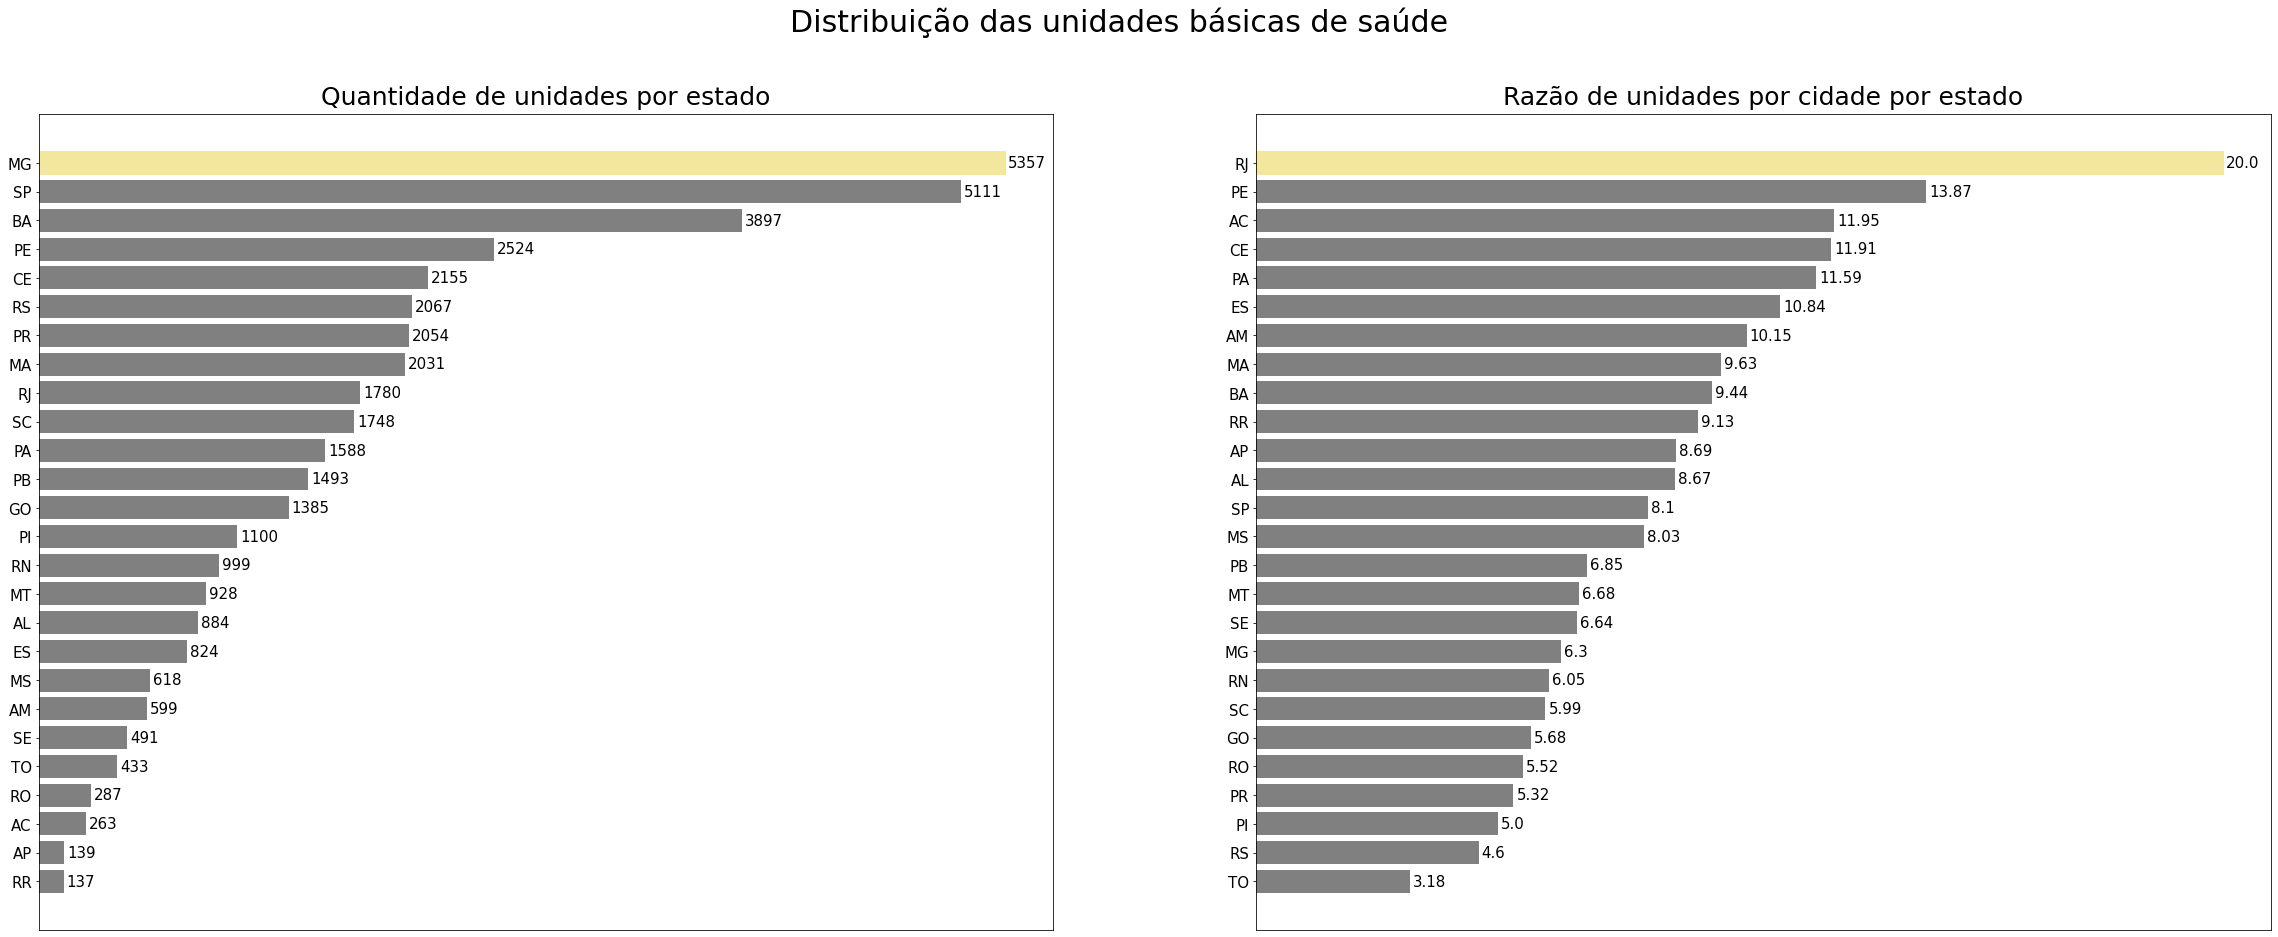

In [8]:
analysis_ubs_uf()

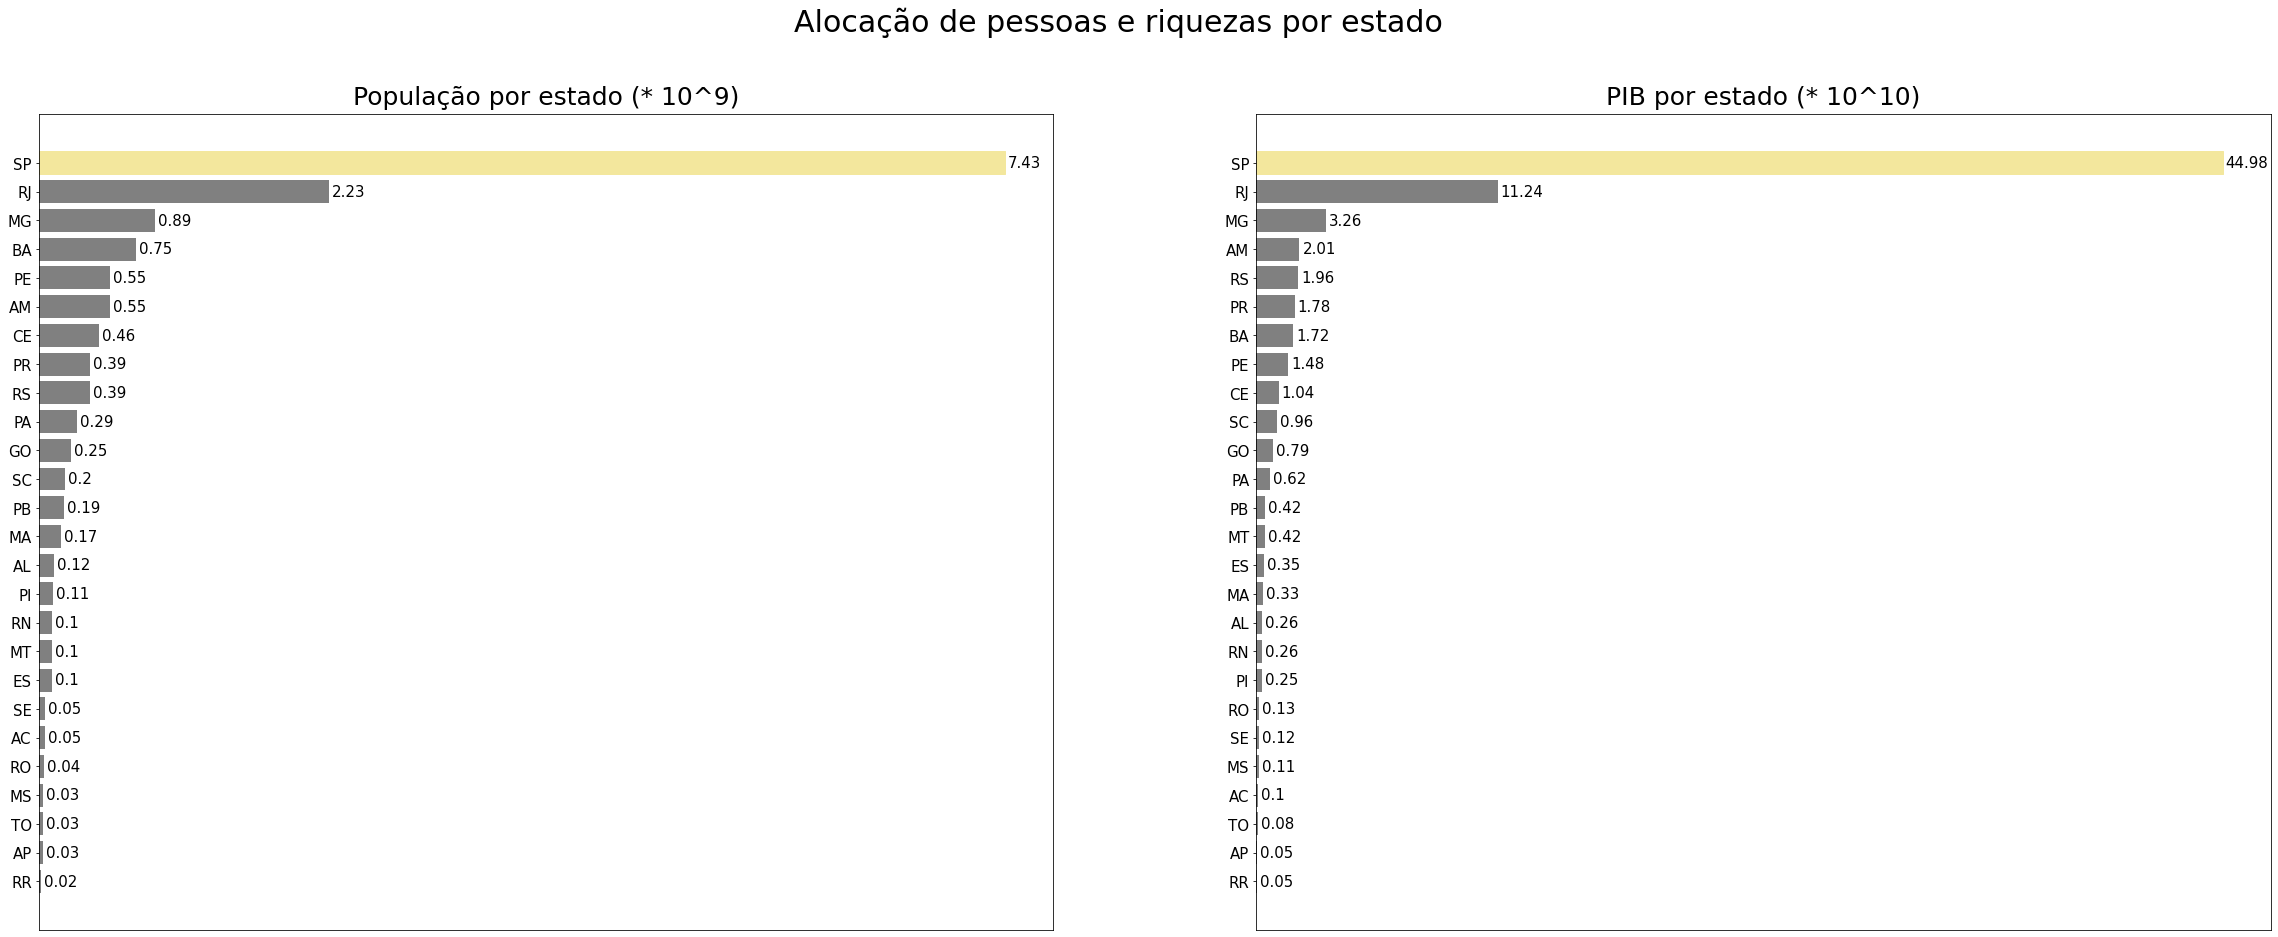

In [9]:
analysis_pop_pib()